<a href="https://colab.research.google.com/github/aldodec/Covid19-Mex/blob/master/Covid19_MX_Logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
from datetime import date
from scipy import stats
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
today = date.today()
print("Updated:", today)

Updated: 2020-04-30


Data and Data Frame

In [0]:
## Data

date = ['2020-02-28','2020-02-29','2020-03-01','2020-03-02','2020-03-03','2020-03-04'
       ,'2020-03-05','2020-03-06','2020-03-07','2020-03-08','2020-03-09','2020-03-10',
       '2020-03-11','2020-03-12','2020-03-13','2020-03-14','2020-03-15','2020-03-16',
       '2020-03-17','2020-03-18','2020-03-19','2020-03-20','2020-03-21','2020-03-22',
        '2020-03-23','2020-03-24','2020-03-25','2020-03-26','2020-03-27','2020-03-28',
        '2020-03-29','2020-03-30','2020-03-31','2020-04-01','2020-04-02','2020-04-03',
        '2020-04-04','2020-04-05','2020-04-06','2020-04-07','2020-04-08','2020-04-09',
        '2020-04-10','2020-04-11','2020-04-12','2020-04-13','2020-04-14','2020-04-15',
        '2020-04-16','2020-04-17','2020-04-18','2020-04-19','2020-04-20','2020-04-21',
        '2020-04-22','2020-04-23','2020-04-24','2020-04-25','2020-04-26','2020-04-27',
        '2020-04-28','2020-04-29']

positives = [3,4,5,5,5,5,5,6,7,7,7,7,11,14,26,41,53,82,93,118,164,203,251,316
                   ,367,405,475,585,717,848,993,1094,1215,1378,1510,1688,1890,2143,
                   2439,2785,3181,3441,3844,4219,4661,5014,5399,5847,6297,6875,7497,
                   8261,8772,9501,10544,11633,12872,13842,14677,15529,16752,17799]

deaths = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,2,2,4,5,6,8,12,16,20,28,29,37,50,60,79,94,
          125,141,174,194,233,273,296,332,406,449,486,546,650,686,712,857,970,1069,1221,1305,
          1351,1434,1569,1732]

## Data Frame

df = pd.DataFrame({'date':date,'positives':positives,'deaths':deaths})
df['date']=pd.to_datetime(df['date'])
df['deaths'] = df['deaths'].replace(0,np.nan)

days_since_first_case = []
for i in df.index:
    days_since_first_case.append(i)
df['days_since_first_case'] = days_since_first_case

## Composite Data

df['log_deaths'] = np.log(df['deaths'])
df['log_positives'] = np.log(df['positives'])

df['daily_deaths'] = df['deaths']-df['deaths'].shift(1)
df['daily_positives'] = df['positives']-df['positives'].shift(1)

df['rel_ch_deaths'] = (df['deaths']/df['deaths'].shift(1)) - 1
df['rel_ch_positives'] = (df['positives']/df['positives'].shift(1)) - 1

df['log_ch_deaths'] = np.log(df['deaths']/df['deaths'].shift(1))
df['log_ch_positives'] = np.log(df['positives']/df['positives'].shift(1))

df['CFR'] = df['deaths']/df['positives']

df['ch_daily_deaths'] = df['daily_deaths']/df['daily_deaths'].shift(1) - 1
df['ch_daily_positives'] = df['daily_positives']/df['daily_positives'].shift(1) - 1

## Days from phase II

phase_II = pd.to_datetime('2020-03-24')
days_since_phaseII_list = []

for i in df.index:
  if i <25:
    days_since_phaseII_list.append(np.nan)
  else:
    days_since_phaseII_list.append(i-25)

df['days_since_phaseII'] = days_since_phaseII_list

days_since_first_death = []
for i in df.index:
  if i <19:
    days_since_first_death.append(np.nan)
  else:
    days_since_first_death.append(i-19)

df['days_since_first_death'] = days_since_first_death

In [68]:
df.head()

,date,positives,deaths,days_since_first_case,log_deaths,log_positives,daily_deaths,daily_positives,rel_ch_deaths,rel_ch_positives,log_ch_deaths,log_ch_positives,CFR,ch_daily_deaths,ch_daily_positives,days_since_phaseII,days_since_first_death
0,2020-02-28,3,NaN,0,NaN,1.098612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-29,4,NaN,1,NaN,1.386294,NaN,1.0,NaN,0.333333,NaN,0.287682,NaN,NaN,NaN,NaN,NaN
2,2020-03-01,5,NaN,2,NaN,1.609438,NaN,1.0,NaN,0.250000,NaN,0.223144,NaN,NaN,0.0,NaN,NaN
3,2020-03-02,5,NaN,3,NaN,1.609438,NaN,0.0,NaN,0.000000,NaN,0.000000,NaN,NaN,-1.0,NaN,NaN
4,2020-03-03,5,NaN,4,NaN,1.609438,NaN,0.0,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN


EDA

Time Evolution

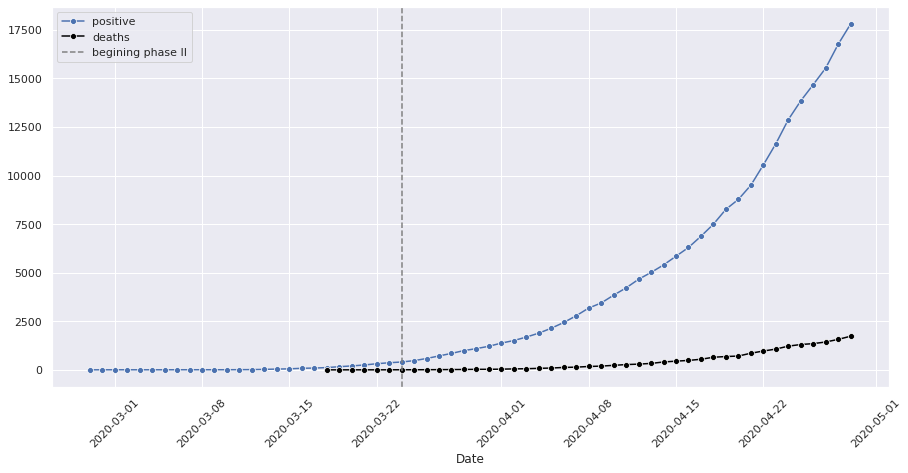

In [69]:
plt.figure(figsize=(15,7))
sns.lineplot(x = 'date',y = 'positives',data = df,marker="o",label = 'positive')
#plt.plot(df['date'],df['positives'].rolling(7).mean(),color = 'blue')
sns.lineplot(x = 'date',y = 'deaths',data = df,marker="o",color = 'black',label='deaths')
#plt.plot(df['date'],df['deaths'].rolling(7).mean(),color = 'black')
plt.axvline(phase_II,color='gray',ls = '--',label = 'begining phase II')
plt.title('')
plt.xlabel('Date')
plt.ylabel('')
plt.xticks(rotation=45)
plt.legend()
plt.show()

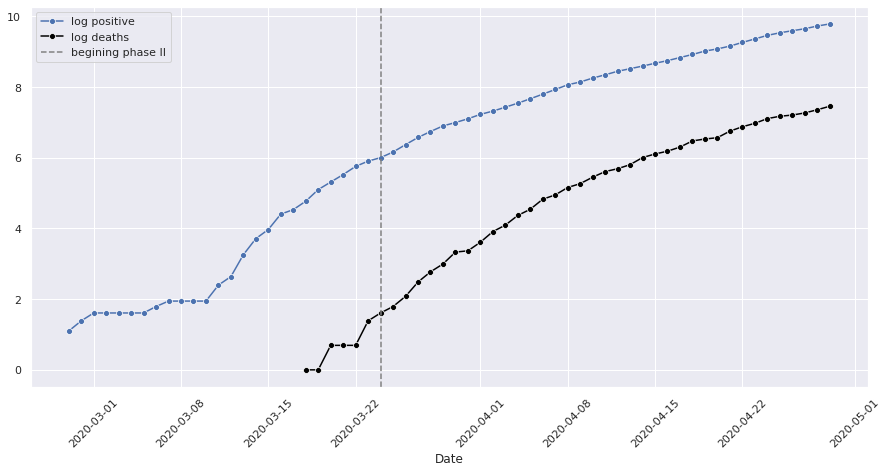

In [70]:
plt.figure(figsize=(15,7))
sns.lineplot(x = 'date',y = 'log_positives',data = df,marker="o",label = 'log positive')
#plt.plot(df['date'],df['log_positives'].rolling(7).mean(),color = 'blue')
sns.lineplot(x = 'date',y = 'log_deaths',data = df,marker="o",color = 'black',label='log deaths')
#plt.plot(df['date'],df['log_deaths'].rolling(7).mean(),color = 'black')
plt.axvline(phase_II,color='gray',ls = '--',label = 'begining phase II')

plt.title('')
plt.xlabel('Date')
plt.ylabel('')
plt.xticks(rotation=45)
plt.legend()
plt.show()

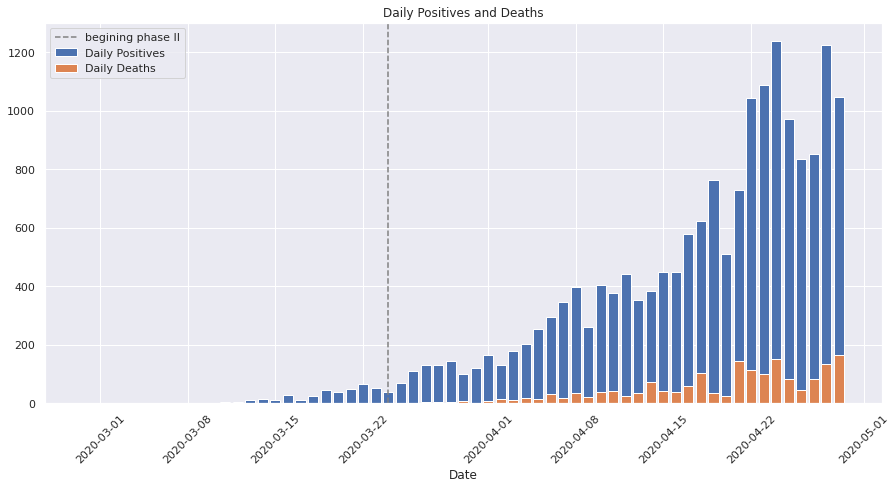

In [71]:
plt.figure(figsize=(15,7))
plt.bar(df['date'],df['daily_positives'],label ='Daily Positives')
plt.bar(df['date'],df['daily_deaths'],label = 'Daily Deaths')
plt.axvline(phase_II,color='gray',ls = '--',label = 'begining phase II')
plt.title('Daily Positives and Deaths')
plt.xlabel('Date')
plt.ylabel('')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

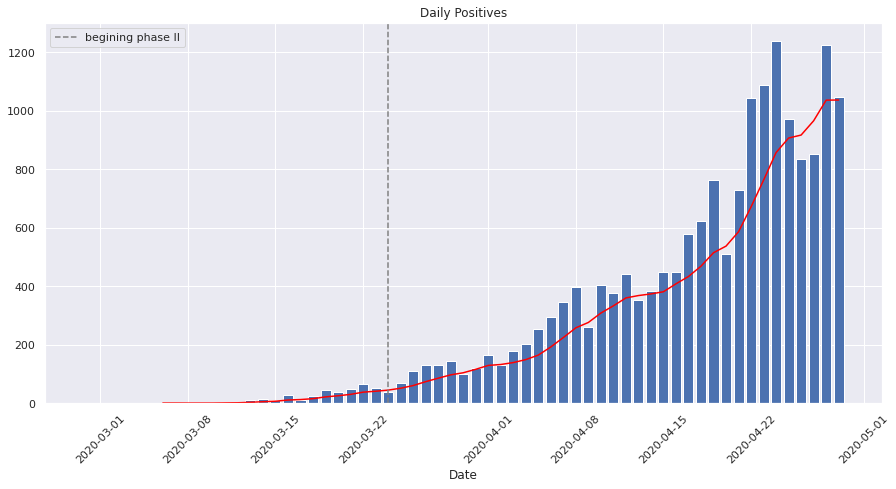

In [72]:
plt.figure(figsize=(15,7))
plt.bar(df['date'],df['daily_positives'])
plt.plot(df['date'],df['daily_positives'].rolling(7).mean(),color = 'red')
plt.axvline(phase_II,color='gray',ls = '--',label = 'begining phase II')
plt.title('Daily Positives')
plt.xlabel('Date')
plt.ylabel('')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

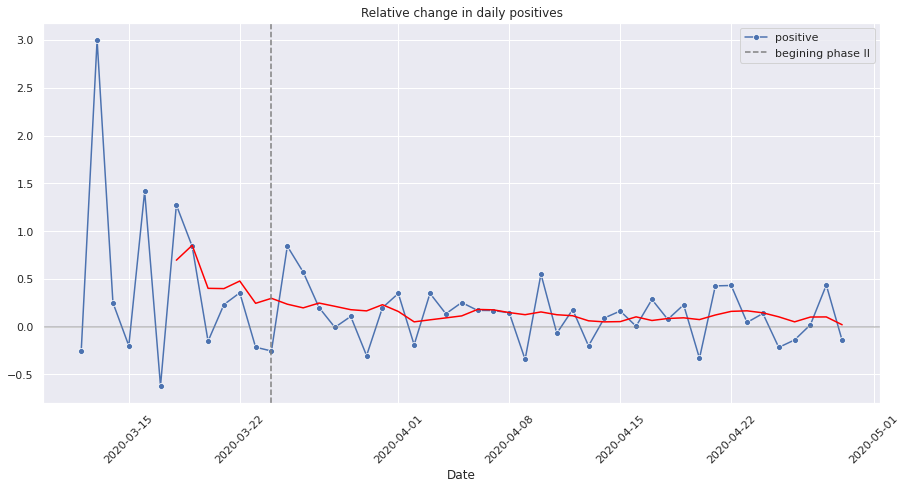

In [73]:
plt.figure(figsize=(15,7))
sns.lineplot(x = 'date',y = 'ch_daily_positives',data = df[13:],marker="o",label = 'positive')
plt.plot(df['date'][13:],df['ch_daily_positives'][13:].rolling(7).mean(),color = 'red')
#plt.plot(df['date'],df['deaths'].rolling(7).mean(),color = 'black')
plt.axvline(phase_II,color='gray',ls = '--',label = 'begining phase II')
plt.axhline(0,color='gray',alpha = 0.5)
plt.title('Relative change in daily positives')
plt.xlabel('Date')
plt.ylabel('')
plt.xticks(rotation=45)
plt.legend()
plt.show()

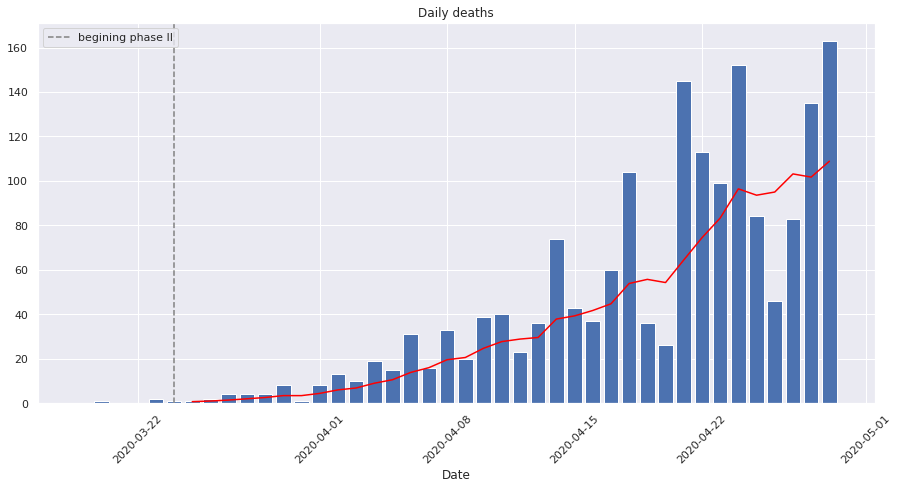

In [74]:
plt.figure(figsize=(15,7))
plt.bar(df['date'],df['daily_deaths'])
plt.plot(df['date'],df['daily_deaths'].rolling(7).mean(),color = 'red')
plt.axvline(phase_II,color='gray',ls = '--',label = 'begining phase II')
plt.title('Daily deaths')
plt.xlabel('Date')
plt.ylabel('')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

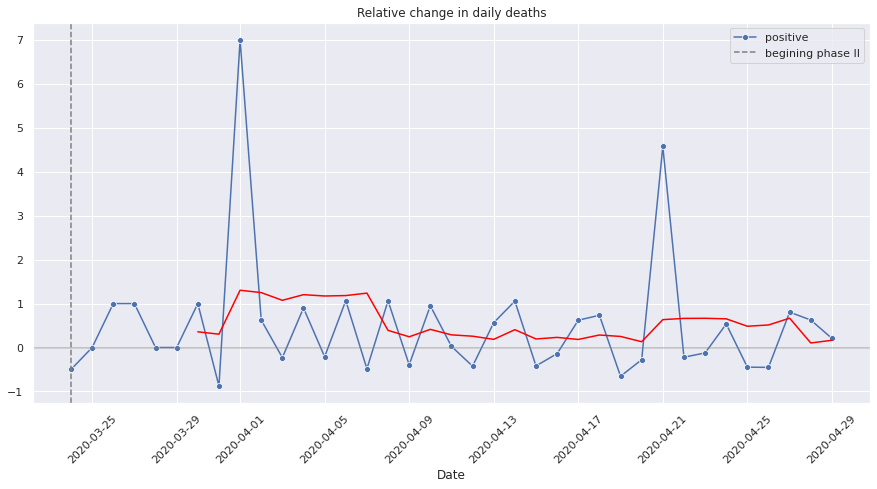

In [75]:
plt.figure(figsize=(15,7))
sns.lineplot(x = 'date',y = 'ch_daily_deaths',data = df[25:],marker="o",label = 'positive')
plt.plot(df['date'][:],df['ch_daily_deaths'][:].rolling(7).mean(),color = 'red')
#plt.plot(df['date'],df['deaths'].rolling(7).mean(),color = 'black')
plt.axvline(phase_II,color='gray',ls = '--',label = 'begining phase II')
plt.axhline(0,color='gray',alpha = 0.5)
plt.title('Relative change in daily deaths')
plt.xlabel('Date')
plt.ylabel('')
plt.xticks(rotation=45)
plt.legend()
plt.show()

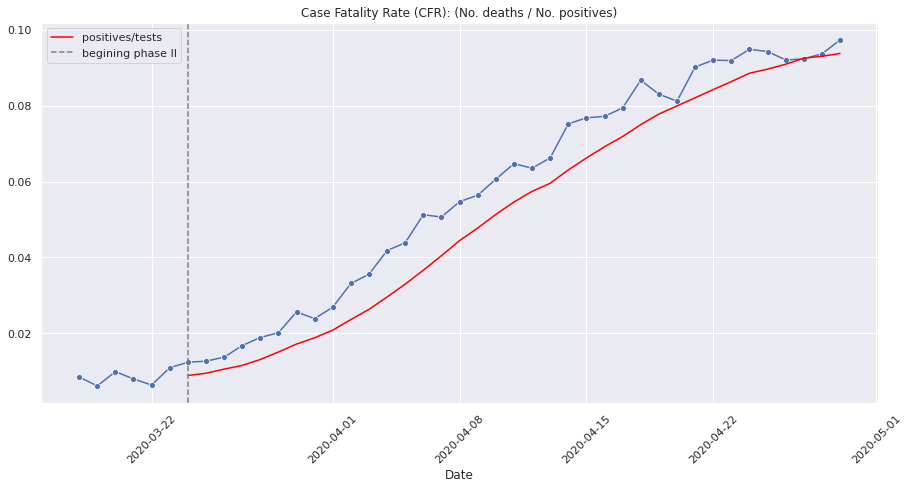

In [76]:
plt.figure(figsize=(15,7))
sns.lineplot(x = 'date',y = 'CFR',data = df,marker="o")
plt.title('Case Fatality Rate (CFR): (No. deaths / No. positives)')
sns.lineplot(x = df['date'][:],y = ((df['CFR']).rolling(7).mean())[:],label = 'positives/tests',color ='red')
plt.axvline(phase_II,color='gray',ls = '--',label = 'begining phase II')
plt.xlabel('Date')
plt.ylabel('')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [0]:
df.replace(np.inf,np.nan,inplace=True)

In [0]:
df.columns

Index(['date', 'positives', 'deaths', 'days_since_first_case', 'log_deaths',
       'log_positives', 'daily_deaths', 'daily_positives', 'rel_ch_deaths',
       'rel_ch_positives', 'log_ch_deaths', 'log_ch_positives', 'CFR',
       'ch_daily_deaths', 'ch_daily_positives', 'days_since_phaseII'],
      dtype='object')

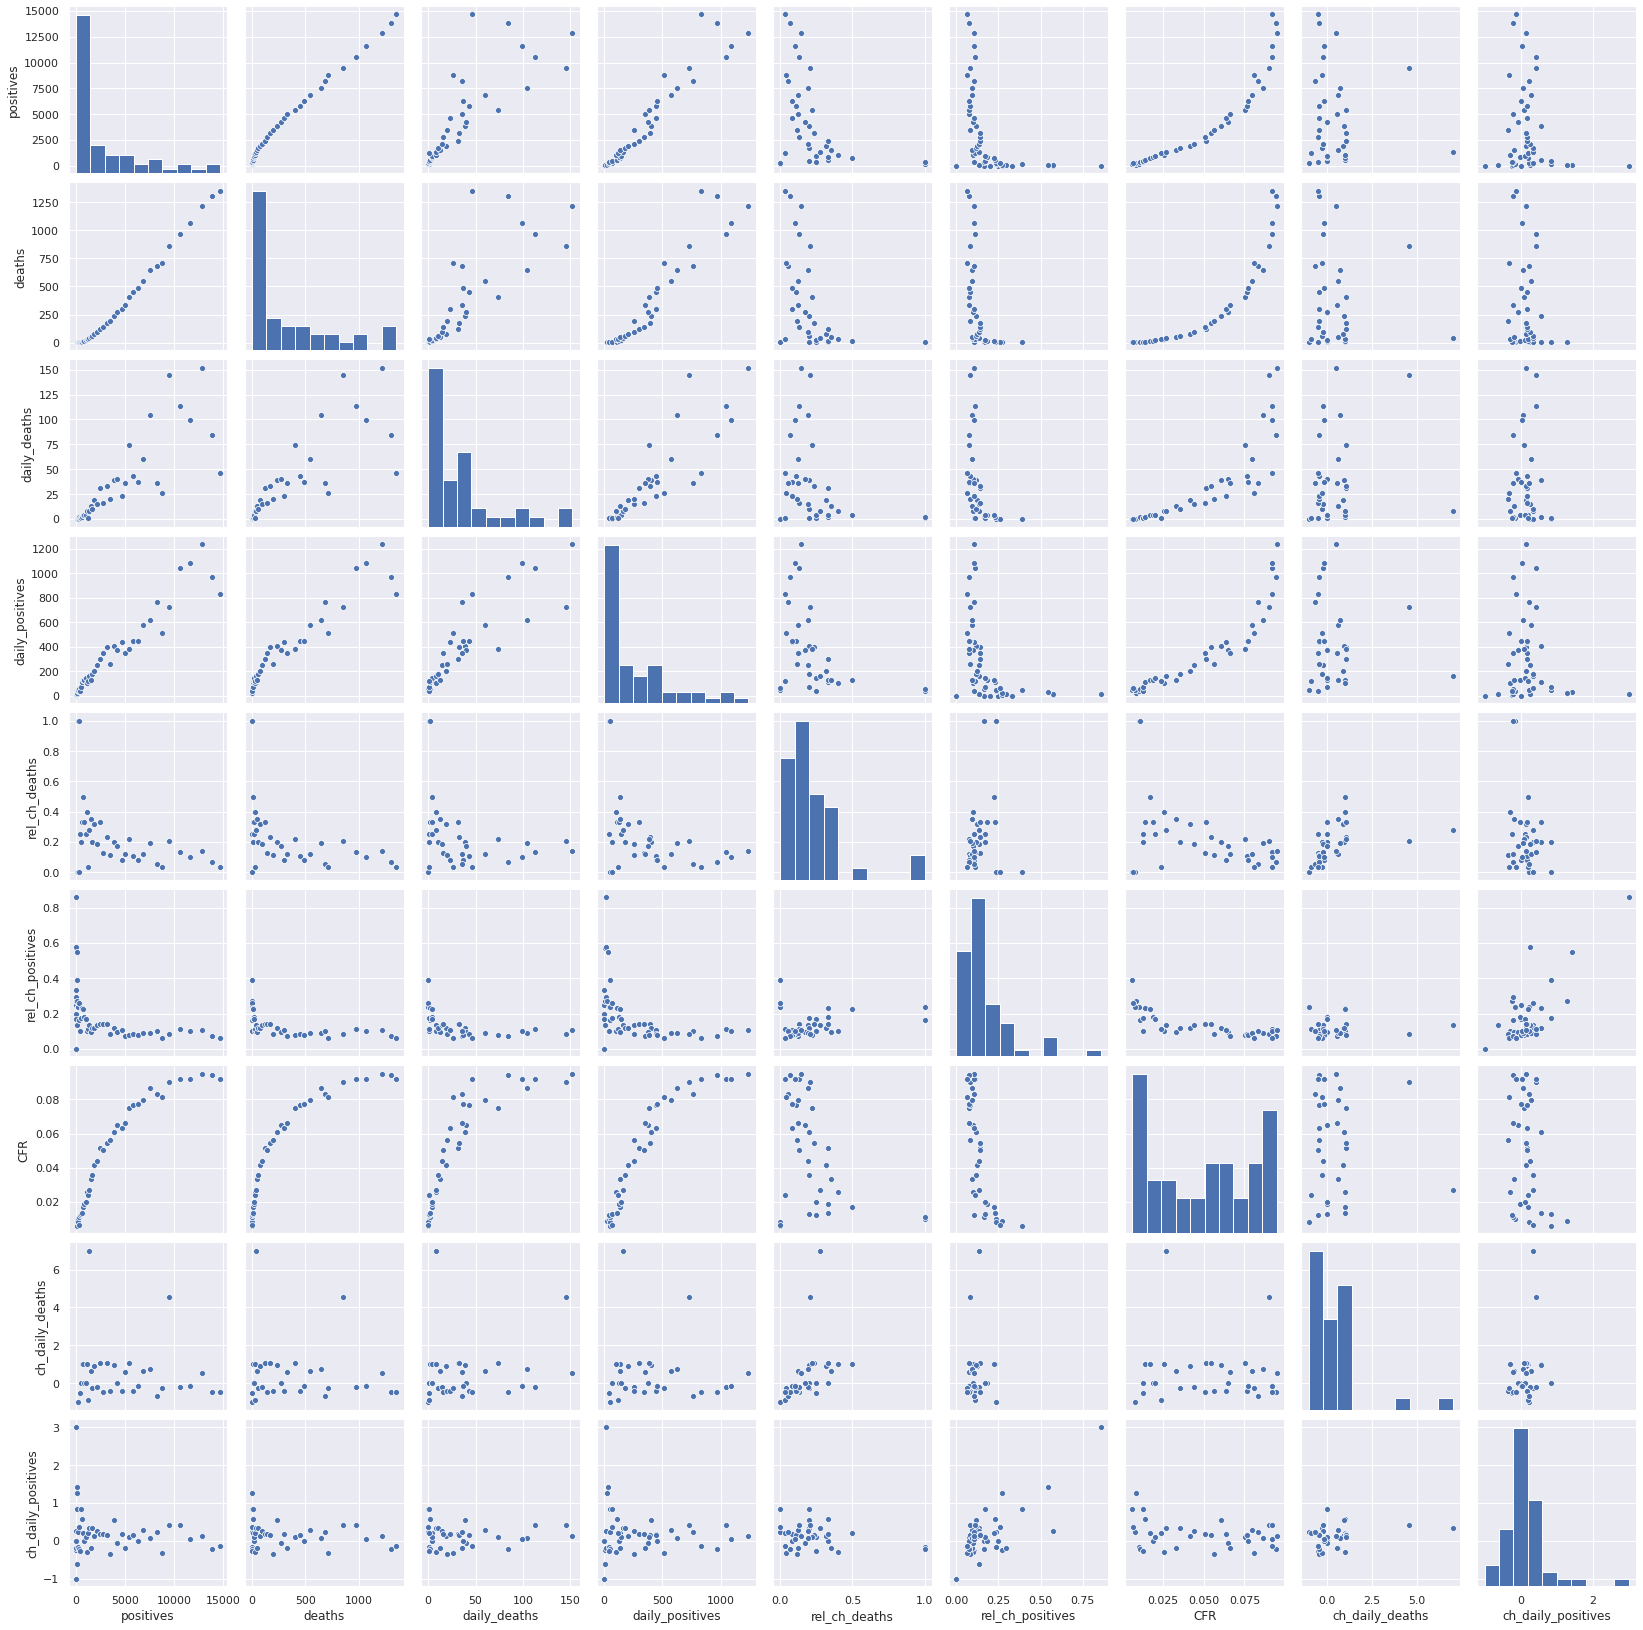

In [0]:
sns.pairplot(df[['positives','deaths','daily_deaths','daily_positives','rel_ch_deaths','rel_ch_positives','CFR','ch_daily_deaths','ch_daily_positives']])

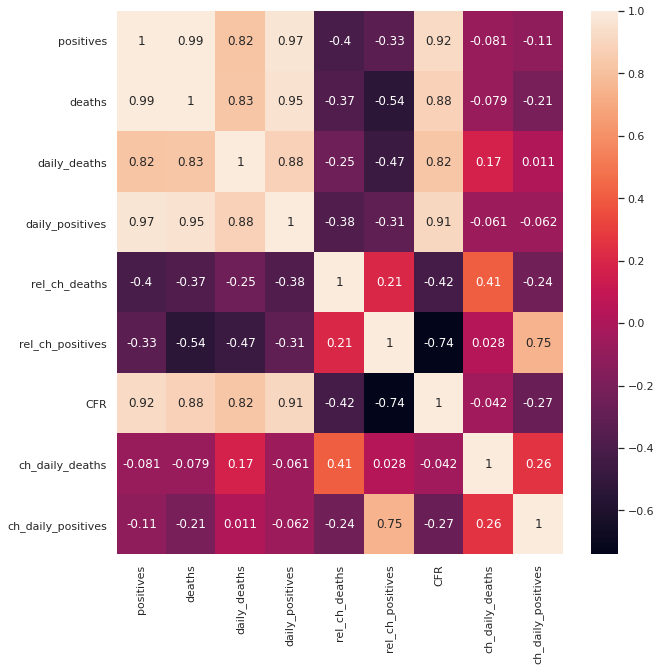

In [0]:
plt.figure(figsize=(10,10))
sns.heatmap(df[['positives','deaths','daily_deaths','daily_positives','rel_ch_deaths','rel_ch_positives','CFR','ch_daily_deaths','ch_daily_positives']].corr(),annot=True)

Logistic Fit

Positive Cases

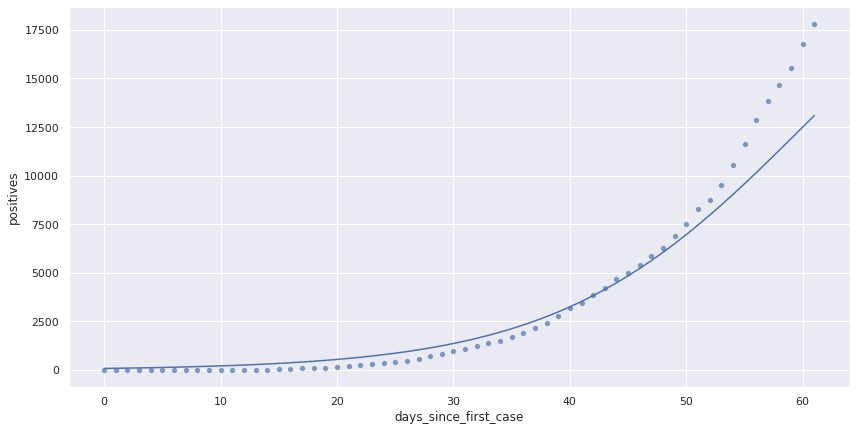

In [77]:
def logistic2(t,t0,a0,b0):  ## starts at zero
  return  a0/(1+np.exp(-b0*(t-t0)))

g = [60,25000,0.095] # make a guess
t = df['days_since_first_case']
n = len(df)
y = np.empty(n)
for i in range(n):
    y[i] = logistic2(t[i],g[0],g[1],g[2])
plt.figure(figsize=(14,7))
sns.scatterplot(x = df['days_since_first_case'],
               y = df['positives'],alpha=0.7,palette='viridis')
sns.lineplot(x = t, y = y)
#df_compare['percentage'].rolling(3).mean().plot(color = 'red')
plt.show()

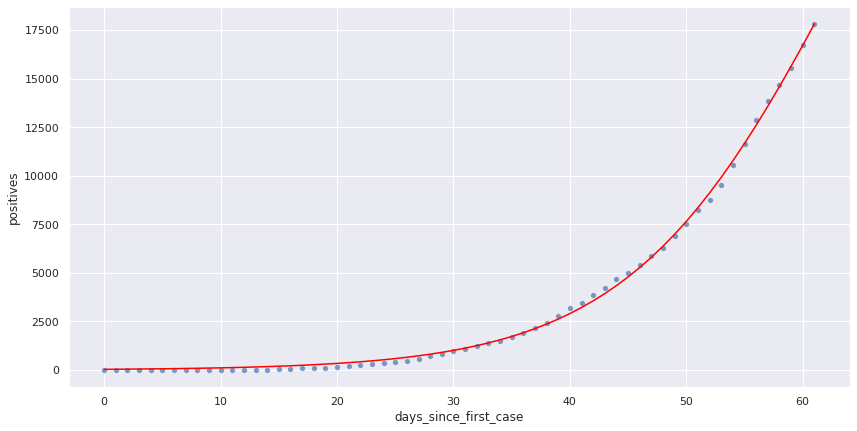

R^2:  0.9989240754872135
t0:  63.25576370309145
Max Infected:  40630.97927304636
Growth Parameter (Beta):  0.11021682120595322


In [78]:
def logistic(t,t0,a0,b0): 
  return  a0/(1+np.exp(-b0*(t-t0)))

g = [70,100000,.12]
#g = [85,12000000,0.08]
#g = [60,25000,1]  # using our guess
t = df['days_since_first_case'].values
pc = df['positives'].values

c, cov = curve_fit(logistic,t,pc,g)

t = df['days_since_first_case']
n = len(df)
y = np.empty(n)

for i in range(n):
    y[i] = logistic(t[i],c[0],c[1],c[2])

plt.figure(figsize=(14,7))
sns.scatterplot(x = df['days_since_first_case'],
                y = df['positives'],alpha=0.7,palette='viridis')
sns.lineplot(x = t, y = y,color = 'red')
plt.show()

print('R^2: ',r2_score(df['positives'],y))
print('t0: ',c[0])
print('Max Infected: ',c[1])
print('Growth Parameter (Beta): ',c[2])

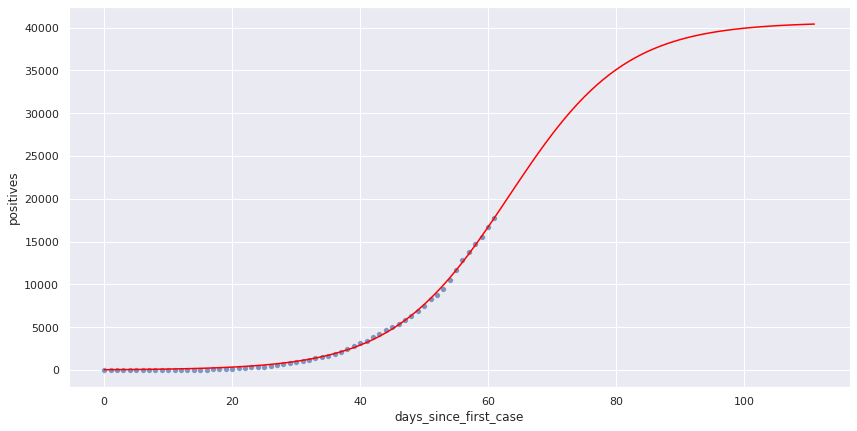

In [80]:
def logistic(t,t0,a0,b0):  # future outlook
  return a0/(1+np.exp(-b0*(t-t0)))

g = [85,12000000,0.08] # 
t = df['days_since_first_case'].values
pc = df['positives'].values

c, cov = curve_fit(logistic,t,pc,g)

t = df['days_since_first_case']
n = len(df)
y = np.empty(n+50)
T = np.empty(n+50)

for i in range(n+50):
    y[i] = logistic(i,c[0],c[1],c[2])
    T[i] = i

plt.figure(figsize=(14,7))
sns.scatterplot(x = df['days_since_first_case'],
                y = df['positives'],alpha=0.7,palette='viridis')
sns.lineplot(x = T, y = y,color = 'red')
plt.show()

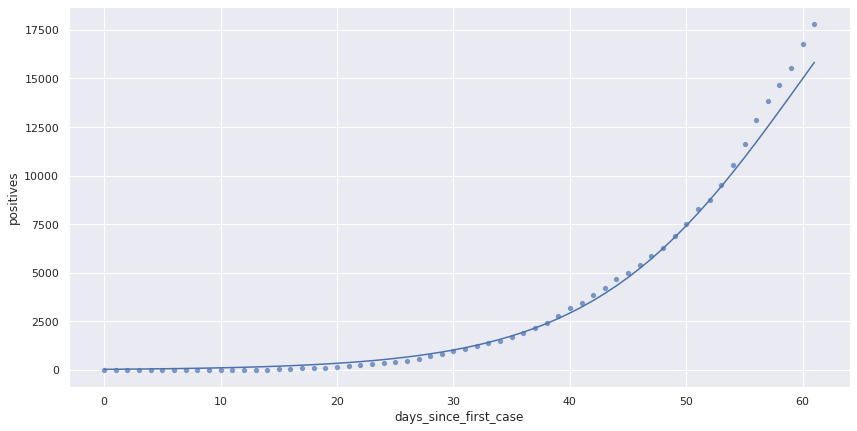

In [81]:
def logistic(t,t0,c0,a0,b0):  ## guessing parameters
  return c0 + a0/(1+np.exp((t-t0)/b0))

g = [60,30000,-30000,9] # make a guess
t = df['days_since_first_case']
n = len(df)
y = np.empty(n)
for i in range(n):
    y[i] = logistic(t[i],g[0],g[1],g[2],g[3])
plt.figure(figsize=(14,7))
sns.scatterplot(x = df['days_since_first_case'],
               y = df['positives'],alpha=0.7,palette='viridis')
sns.lineplot(x = t, y = y)
#df_compare['percentage'].rolling(3).mean().plot(color = 'red')
plt.show()


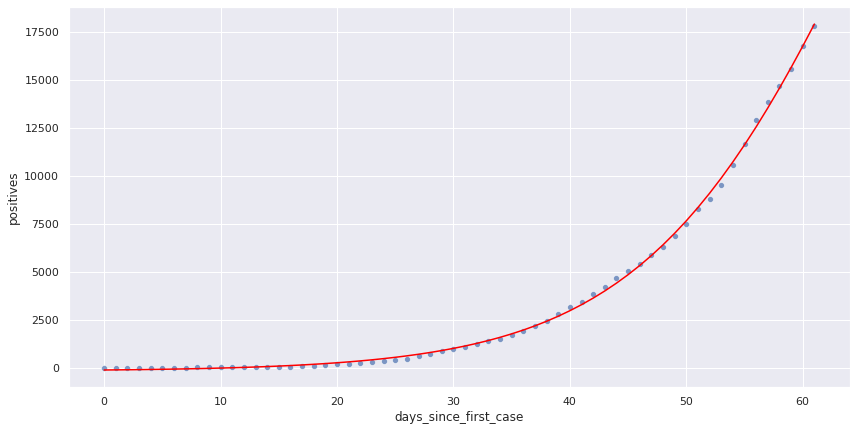

R^2:  0.9992545841148093
t0:  66.36869314032658
Max Infected:  49124.805326604444


In [82]:
def logistic(t,t0,c0,a0,b0): 
  return c0 + a0/(1+np.exp((t-t0)/b0))


g = [60,25000,-30000,9] # using our guess
t = df['days_since_first_case'].values
pc = df['positives'].values

c, cov = curve_fit(logistic,t,pc,g)

t = df['days_since_first_case']
n = len(df)
y = np.empty(n)

for i in range(n):
    y[i] = logistic(t[i],c[0],c[1],c[2],c[3])

plt.figure(figsize=(14,7))
sns.scatterplot(x = df['days_since_first_case'],
                y = df['positives'],alpha=0.7,palette='viridis')
sns.lineplot(x = t, y = y,color = 'red')
plt.show()

print('R^2: ',r2_score(df['positives'],y))
print('t0: ',c[0])
print('Max Infected: ',c[1])
#print('Growth Parameter (Beta): ',c[2])

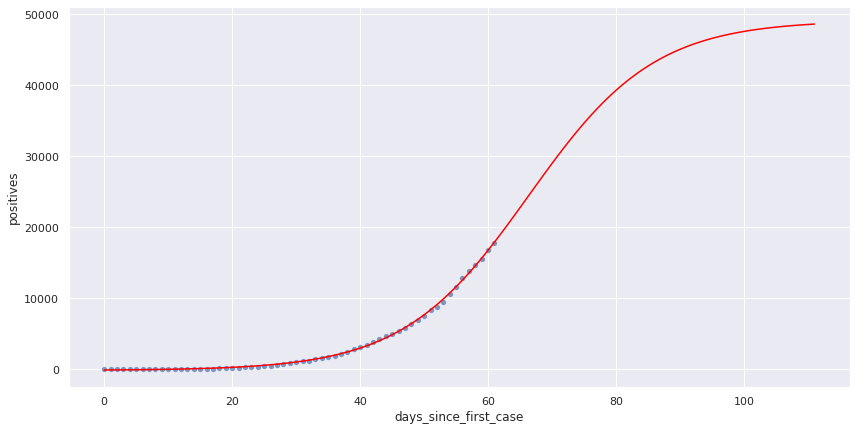

In [84]:
def logistic(t,t0,c0,a0,b0):  # future outlook
  return c0 + a0/(1+np.exp((t-t0)/b0))


g = [80,30000,-30000,9] # 
t = df['days_since_first_case'].values
pc = df['positives'].values

c, cov = curve_fit(logistic,t,pc,g)

t = df['days_since_first_case']
n = len(df)
y = np.empty(n+50)
T = np.empty(n+50)

for i in range(n+50):
    y[i] = logistic(i,c[0],c[1],c[2],c[3])
    T[i] = i

plt.figure(figsize=(14,7))
sns.scatterplot(x = df['days_since_first_case'],
                y = df['positives'],alpha=0.7,palette='viridis')
sns.lineplot(x = T, y = y,color = 'red')
plt.show()

"*estiman que el pico máximo de contagio llegará entre el 8 y 10 de mayo, de ahí se mantendrá constante y podría comenzar a disminuir el 25 de mayo.*"

https://www.infobae.com/america/mexico/2020/04/16/grafica-del-coronavirus-en-mexico-entre-el-8-y-10-de-mayo-se-estima-el-pico-maximo-de-infectados/

In [0]:
54 + 16

70

In [0]:
54+18

72

In [0]:
df.replace(np.inf,np.nan,inplace=True)

In [85]:
day0 = np.empty(len(df))
for j in range(len(df)):
  for i in range(j+1):
    if (df['positives'][j]/df['positives'][j-i])//2 == 1:
      print(j,i,df['positives'][j],df['positives'][j-i],j-i)
      break

7 7 6 3 0
8 8 7 3 0
9 9 7 3 0
10 10 7 3 0
11 11 7 3 0
12 6 11 5 6
13 2 14 7 11
14 2 26 11 12
15 2 41 14 13
16 2 53 26 14
17 2 82 41 15
18 3 93 41 15
19 3 118 53 16
20 3 164 82 17
21 3 203 93 18
22 3 251 118 19
23 4 316 118 19
24 4 367 164 20
25 5 405 164 20
26 5 475 203 21
27 5 585 251 22
28 5 717 316 23
29 4 848 405 25
30 4 993 475 26
31 5 1094 475 26
32 5 1215 585 27
33 6 1378 585 27
34 6 1510 717 28
35 7 1688 717 28
36 7 1890 848 29
37 7 2143 993 30
38 6 2439 1215 32
39 6 2785 1378 33
40 6 3181 1510 34
41 6 3441 1688 35
42 6 3844 1890 36
43 7 4219 1890 36
44 7 4661 2143 37
45 7 5014 2439 38
46 8 5399 2439 38
47 8 5847 2785 39
48 9 6297 2785 39
49 9 6875 3181 40
50 9 7497 3441 41
51 9 8261 3844 42
52 9 8772 4219 43
53 9 9501 4661 44
54 9 10544 5014 45
55 9 11633 5399 46
56 8 12872 6297 48
57 8 13842 6875 49
58 9 14677 6875 49
59 9 15529 7497 50
60 9 16752 8261 51
61 9 17799 8772 52


In [86]:
index = []
days_to_2 = []

for j in range(len(df)):
  for i in range(j+1):
    if (df['daily_deaths'][j]/df['daily_deaths'][j-i])//2 == 1:
      print(j,i,df['daily_deaths'][j],df['daily_deaths'][j-i],j-i)
      index.append(j)
      days_to_2.append(i)
      break

24 3 2.0 1.0 21
27 1 2.0 1.0 26
28 1 4.0 2.0 27
29 2 4.0 2.0 27
30 3 4.0 2.0 27
31 1 8.0 4.0 30
33 3 8.0 4.0 30
34 4 13.0 4.0 30
35 5 10.0 4.0 30
36 3 19.0 8.0 33
37 7 15.0 4.0 30
38 1 31.0 15.0 37
39 6 16.0 8.0 33
40 1 33.0 16.0 39
41 6 20.0 10.0 35
42 3 39.0 16.0 39
43 2 40.0 20.0 41
44 9 23.0 10.0 35
45 6 36.0 16.0 39
46 1 74.0 36.0 45
47 6 43.0 20.0 41
48 9 37.0 16.0 39
49 5 60.0 23.0 44
50 2 104.0 37.0 48
51 12 36.0 16.0 39
52 17 26.0 10.0 35
53 4 145.0 60.0 49
54 3 113.0 36.0 51
55 3 99.0 26.0 52
56 7 152.0 60.0 49
57 5 84.0 26.0 52
58 14 46.0 23.0 44
59 7 83.0 26.0 52
60 2 135.0 46.0 58
61 3 163.0 46.0 58


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [0]:
df_to_double = pd.DataFrame({'days_since_first_case':index,'days_to_double':days_to_2})

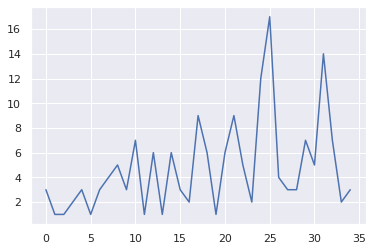

In [88]:
plt.plot(df_to_double['days_to_double'])

Fit with estimated real cases

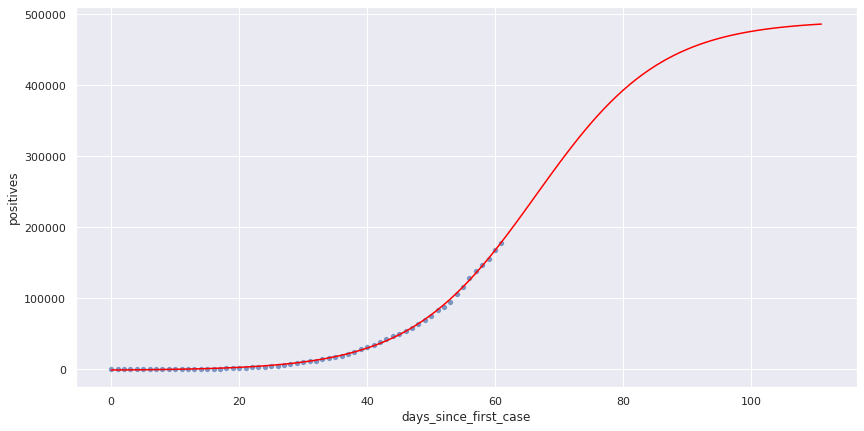

t0:  66.36863913498506
Max Infected:  491246.43628294975


In [89]:
def logistic(t,t0,c0,a0,b0):  # future outlook
  return c0 + a0/(1+np.exp((t-t0)/b0))


g = [80,30000,-30000,9] # 
t = df['days_since_first_case'].values
pc = 10*df['positives'].values

c, cov = curve_fit(logistic,t,pc,g)

t = df['days_since_first_case']
n = len(df)
y = np.empty(n+50)
T = np.empty(n+50)

for i in range(n+50):
    y[i] = logistic(i,c[0],c[1],c[2],c[3])
    T[i] = i

plt.figure(figsize=(14,7))
sns.scatterplot(x = df['days_since_first_case'],
                y = 10*df['positives'],alpha=0.7,palette='viridis')
sns.lineplot(x = T, y = y,color = 'red')
plt.show()

#print('R^2: ',r2_score(10*df['positives'],y))
print('t0: ',c[0])
print('Max Infected: ',c[1])
#print('Growth Parameter (Beta): ',c[2])

Fit with deaths

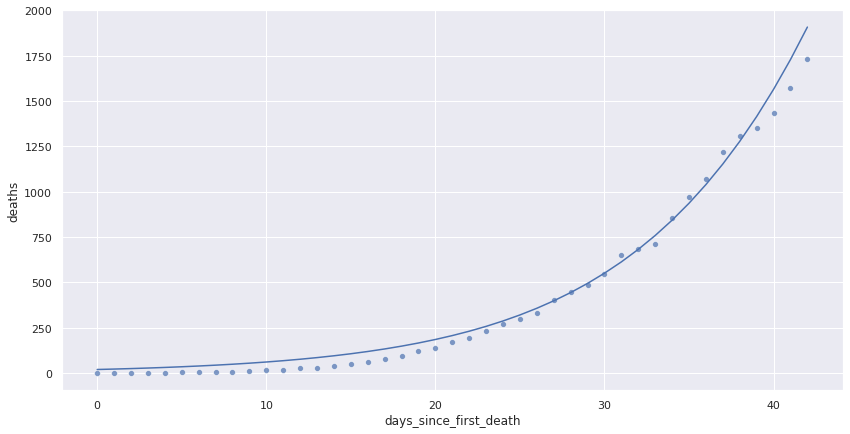

In [90]:
def logistic(t,t0,c0,a0,b0):  ## guessing parameters
  return c0 + a0/(1+np.exp((t-t0)/b0))

g = [60,16000,-16000,9] # make a guess
t = df['days_since_first_death']
n = len(df)
y = np.empty(n)
for i in range(n):
    y[i] = logistic(t[i],g[0],g[1],g[2],g[3])
plt.figure(figsize=(14,7))
sns.scatterplot(x = df['days_since_first_death'],
               y = df['deaths'],alpha=0.7,palette='viridis')
sns.lineplot(x = t, y = y)
#df_compare['percentage'].rolling(3).mean().plot(color = 'red')
plt.show()


In [0]:
df_deaths = df[['days_since_first_death','deaths']]

In [92]:
df_deaths.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [65]:
(2747.480624993691)/(51705.40788482568)

0.053137200486141255

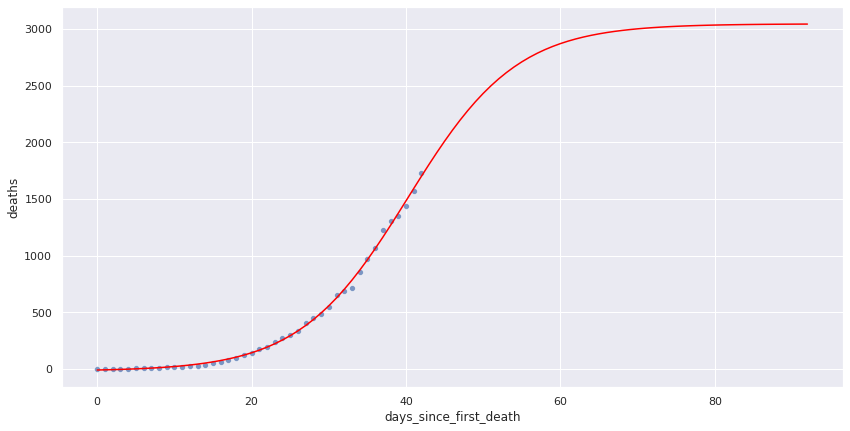

t0:  40.2744223652316
Max Deaths:  3044.5929218816723


In [93]:
def logistic(t,t0,c0,a0,b0):  # future outlook
  return c0 + a0/(1+np.exp((t-t0)/b0))


g =  [60,16000,-16000,9] # 
t = df_deaths['days_since_first_death'].values
pc = df_deaths['deaths'].values

c, cov = curve_fit(logistic,t,pc,g)

t = df_deaths['days_since_first_death']
n = len(df_deaths)
y = np.empty(n+50)
T = np.empty(n+50)

for i in range(n+50):
    y[i] = logistic(i,c[0],c[1],c[2],c[3])
    T[i] = i

plt.figure(figsize=(14,7))
sns.scatterplot(x = df_deaths['days_since_first_death'],
                y = df_deaths['deaths'],alpha=0.7,palette='viridis')
sns.lineplot(x = T, y = y,color = 'red')
plt.show()

#print('R^2: ',r2_score(df_deaths['deaths'],y))
print('t0: ',c[0])
print('Max Deaths: ',c[1])
#print('Growth Parameter (Beta): ',c[2])

In [95]:
491246.43628294975*0.1

49124.64362829498

In [96]:
3044.5929218816723*10

30445.929218816724